In [1]:
%matplotlib inline

In [2]:
import sys, os

In [3]:
sys.path.append('/Users/nicolasf/operational/Presentation_Cartography/resource_converter/')

In [4]:
from read_gridData import read_gridData
from write_gridData import write_gridData
from NN_interp import NN_interp

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd

In [6]:
from glob import glob

In [7]:
var = 'BAA'

In [8]:
dpath = os.path.join('/Volumes/GDATA/data/CRW', var)

In [9]:
lfiles = glob(os.path.join(dpath, '*.nc'))

In [10]:
dset = xr.open_mfdataset(lfiles)

In [11]:
dset.load()

<xarray.Dataset>
Dimensions:       (lat: 3600, lon: 7200, time: 29)
Coordinates:
  * lat           (lat) float32 89.975 89.925 89.875 89.825 89.775 89.725 ...
  * lon           (lon) float32 -179.975 -179.925 -179.875 -179.825 -179.775 ...
  * time          (time) datetime64[ns] 2017-10-07T12:00:00 ...
Data variables:
    surface_flag  (time, lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    CRW_BAA       (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    crs           (time) int64 -32767 -32767 -32767 -32767 -32767 -32767 ...
Attributes:
    Conventions:                CF-1.6, ACDD-1.3, Unidata Observation Dataset...
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    title:                      NOAA Coral Reef Watch Daily Global 5-km Satel...
    summary:                    This is a product of NOAA Coral Reef Watch da...
    references:                 Liu, G, Heron SF, Eakin CM, Muller-Karger FE,...
    institution:                NOAA/NESDIS/S

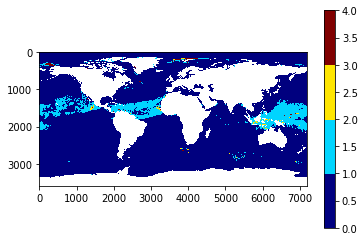

In [12]:
im = plt.imshow(dset['CRW_BAA'][-1,:,:], cmap=plt.get_cmap('jet', 4)); plt.colorbar(im)

In [13]:
# lats = dset.lat.data
# lons = dset.lon.data

In [14]:
# i = np.where(lons > 0.)[0][0]

In [15]:
# new_lons = lons.copy()

In [16]:
# new_lons = np.concatenate([new_lons[i::],new_lons[0:i]])

In [17]:
# dset['lon'] = (('lon'), new_lons)

In [18]:
# data = np.concatenate((dset['CRW_BAA'].data[:,:,i::], dset['CRW_BAA'].data[:,:,0:i]), axis=2)

In [19]:
# dset['CRW_BAA'] = (('time','lat','lon'), data)

In [20]:
def make_map(dset, var='CRW_BAA', itime=0, ll_lon=-180., ur_lon=180., ll_lat=-45, ur_lat=45, central_longitude=180., cshrink=0.3, fname=None): 
    
    from matplotlib import colors
    from cartopy import crs as ccrs
    from cartopy import feature as cfeature 
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    
    ticks = [0, 1, 2, 3, 4]
    
    bounds = [-0.5,0.5,1.5, 2.5, 3.5, 4.5]
    
    ticklabels = ['No stress', 'Watch', 'Warning', 'Alert Level 1', 'Alert Level 2']
    
    cmap = colors.ListedColormap(['#66ffff','#ffff00','#ff9933','#ff0000','#cc3300'])
    
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    sub = dset.isel(time=itime)
    date = pd.to_datetime(sub.time.data)
    sub = sub.squeeze() 
    sub = sub.sel(lon=slice(ll_lon, ur_lon), lat=slice(ur_lat, ll_lat)) 
    data = sub[var].data
    
    lons = sub.lon
    lats = sub.lat 
    
    proj = ccrs.PlateCarree(central_longitude=central_longitude)
    
    f, ax = plt.subplots(figsize=(10,8), subplot_kw={'projection':proj})
    
    ax.coastlines('50m')
    
    im = ax.pcolormesh(lons - central_longitude, lats, data, cmap=cmap, norm=norm)

    cb = plt.colorbar(im, cmap=cmap, norm=norm, boundaries=bounds, ticks=ticks, shrink=cshrink)

    cb.ax.yaxis.set_ticklabels(ticklabels); 

    xticks = np.arange(-180, 180, 40)
    yticks = np.arange(-90., 90., 30.)

    gl = ax.gridlines(draw_labels=False, lw=0.5, linestyle=':', xlocs=xticks, ylocs=yticks)

    ax.set_xticks(xticks, crs=proj)

    ax.set_yticks(yticks, crs=proj)

    lon_formatter = LongitudeFormatter(zero_direction_label=True, dateline_direction_label=True)

    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    ax.set_title("CRW {0}, {1:%Y-%m%d}".format(var, date))

    ax.set_extent([lons.data.min() - central_longitude, lons.data.max() - central_longitude, lats.data.min(), lats.data.max()], crs=proj)

    plt.tight_layout()
    
    if fname is None: 
        fname = "../figures/{0}_{1:%Y%m%d}.png".format(var, date)

    f.savefig(fname, dpi=200)
    
    sub.close()
    
    plt.close(f)
    
    
    

In [21]:
# make_map(dset)

In [22]:
for itime in range(len(dset.time)): 
    make_map(dset, itime=itime)

In [23]:
var='CRW_BAA'

In [24]:
from collections import OrderedDict

In [25]:
nlon = len(dset['lon'])

nlat = len(dset['lat'])

minlon = np.float32(min(dset['lon']).data)

minlat = np.float32(min(dset['lat']).data)

maxlon = np.float32(max(dset['lon']).data)

maxlat = np.float32(max(dset['lat']).data)

valid_range = [np.float32(dset[var].min().min().min()), np.float32(dset[var].max().max().max())]

In [26]:
dirout = 'BAA'

In [27]:
if not os.path.exists('../outputs/{}'.format(dirout)): 
    os.mkdir('../outputs/{}'.format(dirout))

In [28]:
for itime in range(len(dset.time)): 
    sub = dset.isel(time=itime)
    date = pd.to_datetime(sub.time.data)
    data = sub[var].data
    data_to_write = NN_interp(data)
    
    meta = OrderedDict([('header', 'VCDATA02'),
         ('width', nlon),
         ('height', nlat),
         ('ncomponents', 1),
         ('bounds', [maxlat, minlat, minlon, maxlon]),
         ('vname', var),
         ('level', 'MeanSea'),
         ('units', 'BAA'),
         ('valid_range', valid_range),
         ('timestamp', date)])
    
    fname_out = "{}_{:%Y%m%d}.gridData".format(var, date)
     
    write_gridData('../outputs/{}/{}'.format(dirout, fname_out), \
               meta, \
               data_to_write, \
               flip=True)
    sub.close()

In [29]:
import json

In [31]:
SetDescription = {}
SetDescription['description'] = "CRW BAA"
SetDescription['errorAgeHours'] = 24 * 365 * 10
SetDescription['name'] = "CRW BAA"
SetDescription['provider'] = "NOAA"
SetDescription['setType'] = "Model"
SetDescription['warnAgeHours'] = 12 * 365 * 10
with open('../outputs/{}/SetDescription.json'.format(dirout),'w') as f: 
    json.dump(SetDescription, f)

In [38]:
!ls -l ../outputs/BAA/*.gridData | wc -l 

      29


In [39]:
c = 29

In [40]:
with open('../outputs/{}/SetComplete.txt'.format(dirout), 'w') as f: 
    f.write(str(c))